## Principles and applications in data mining - CAP 359

Exploratory Analysis of Meteorological Radar Dataset

Project for course Principles and applications in data mining - CAP 359

#### Insctructor:
- Dr. Rafael Santos

#### Student:
- Helvecio Leal Neto

#### Schedule

 - [x] Data reading
 - [x] Data visualization
 - [x] Preprocessing
 - [x] Cluster detection algorithm
 - [x] Create Data Functions
 - [x] Visualization Radar image


### About

This work is part of the suite of applications for the Introduction to Data Science (CAP-394) course offered by the National Institute for Space Research.

The purpose of this paper is to perform an exploratory analysis of radar data, gathering raw data, processing it and understanding the dynamics of cloud location from its center of mass, as well as counting the number of clusters per period. At the end of the exploratory process it will be possible to estimate the behavior of the clouds and relate their geographical location as well as correlate average precipitation rates per hour.



### The Data

The data analyzed in this example consists of NC (NetCDF4) files. Each file corresponds to Rain Rate measurements collected by the Amazon Protection System (SIPAM) radar during the GoAmazon experiment periods, starting from January 2014 to December 2015, such files contain data on 12-minute time intervals. The dataset provides rain data over 2.5km from S-Band Radar located in lat: -3.148556, lon: -59.992000. Data dimensionality consists of a two-dimensional (241x241) matrix containing rain rate values, the Radar Radius range is approximately 240 km, covering an area of 1,500 km² over the state of Amazonas (Brazil).


Overview: "S-band radar volumes from Manaus, Brazil were shared by SIPAM for the time period beginning in January 2014 to December 2015 partially coinciding with the GOAmazon field campaign. The corrected radar reflectivity from each volume were interpolated to a fixed grid and the rainfall products were generated. A single Z-R relation (Z=174.8R^1.56) was created using 2014 wet-season impact disdrometer data and applied to the 2.5 km SIPAM Manaus S-Band CAPPI data to generate rain rates for each radar volume. This is version 2.0a of the dataset, which benefits from improved quality control procedures to remove non-meteorological data. " Schumacher

https://www.arm.gov/research/campaigns/amf2014goamazon

### Implementation
##### Libraries
- xarray
- numpy
- pandas
- geopandas
- matplotlib
- shapely
- sklearn.cluster
- animaplot

In [139]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from shapely.geometry import Polygon
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from osgeo import gdal
from osgeo import osr

#!conda install -y -c anaconda netcdf4

In [2]:
### System variables
PATH = 'data/radar/'
DAY = sorted(os.listdir(PATH))[0]

#### READ FIRST FILES TO LOAD GLOBAL VARIABLES

In [3]:
first_file = PATH+str(DAY)+'/'+str(sorted(os.listdir(PATH+str(DAY)))[0])
try:
    xds = xr.open_dataset(first_file)
except Exception as e:
    print('File not found')
    
RUNIT = xds.rain_rate.units
RKM = xds.rain_rate.height_km
LON = xds.lon0.data                 ### Coordinate Longitude Matrix
LAT = xds.lat0.data                 ### Corrdinate Latitude Matrix
X0 = xds.x0                         ### Matrix of points
Y0 = xds.y0
RADAR = (np.median(LON),np.median(LAT))

In [4]:
def read_data(date):
    
    path = 'data/radar/'
    dataset = []
    interval = len(os.listdir(path+str(date)))    
    
    # Original grid dimensions
    nx = 241
    ny = 241

    # Define container
    frames = np.zeros( (interval, nx, ny ) )    
    
    for i in range(interval):
        d = str(path)+str(date)+'/'
        file = (sorted(os.listdir(path+str(date)))[i])
        xds = xr.open_dataset(d+file)
        rr = xds.rain_rate
        frames[i] =  rr
            
    return frames

In [5]:
### Simple example visualization
DAY = DAY
figtime = 0
frames = read_data(DAY)

In [6]:
clevs = [0,1,2.5,5,10,20,30,40,50,60,70,80,90,100]
cmap_data = ['gainsboro','deepskyblue','dodgerblue','dodgerblue','dodgerblue','blue','chartreuse','limegreen','green','darkgreen','yellow',
             'gold','orange','magenta','darkmagenta','darkmagenta']
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)
levels = np.arange(0,100,1)
clevels = np.arange(40,100,50)

In [7]:
for i in range(len(frames)):
    filename = sorted(os.listdir(PATH+str(DAY)))[i]
    plt.figure(figsize=(9,7))
    plt.contourf(LON,LAT,frames[i],levels=levels,cmap=cmap,norm=norm)
    plt.title(filename, fontsize=12)
    clb = plt.colorbar()
    clb.set_label('Rain fall mm/h', fontsize=12)
    plt.ylabel('Latitude', labelpad=40, fontsize=12)
    plt.xlabel('Longitude', labelpad=60, fontsize=12)
    plt.savefig('output/figs/sbmn_rain_rates_'+str(i)+'.png')
    plt.close()
!convert -delay 50 -loop 0 ~/Dropbox/INPE/PROPOSTA/CAP-359/output/figs/*.png ~/Dropbox/INPE/PROPOSTA/CAP-359/output/figs/gif-animada.gif
!rm ~/Dropbox/INPE/PROPOSTA/CAP-359/output/figs/*.png

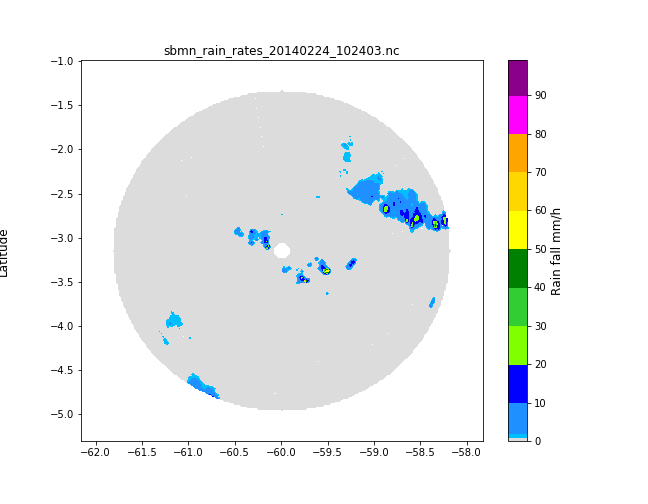

In [8]:
from IPython.display import Image
with open('/home/hneto/Dropbox/INPE/PROPOSTA/CAP-359/output/figs/gif-animada.gif','rb') as file:
    display(Image(file.read()))

### Pre-processing Data

In [9]:
def pre_processing(time,threshold):
    np.warnings.filterwarnings('ignore')
    
    rs =  (np.where(time != np.nan) and np.where(time > threshold))
    rs = np.asanyarray(rs)
    pe = pd.DataFrame({'x':rs[0],'y':rs[1]})
    return pe

In [10]:
DAY = DAY
figtime = 15
threshold = 21.8
frames = read_data(DAY)
pre_processing(frames[figtime],threshold).head()

,x,y
0,105,163
1,105,164
2,106,163
3,106,164
4,106,165


In [11]:
def clusterization(time):
    te = time.copy()
    
    te = time[['x','y']].values
    output = pd.DataFrame()

    ms = DBSCAN(algorithm='auto', eps=1, metric='euclidean',
    metric_params=None, min_samples=3, n_jobs=None, p=None)
    
    ms.fit(te)
    labels = ms.labels_
    n_clusters_ = len(np.unique(labels))
    output['cluster']=labels
    output['x1'] = te[:,0]
    output['y1'] = te[:,1]
    
    output = output[output.cluster != -1]
    return output

In [12]:
DAY = DAY
figtime = 15
threshold = 21.8
frames = read_data(DAY)
pre = pre_processing(frames[figtime],threshold)
clust = clusterization(pre)

In [18]:
def create_data(day,time,frames,clusters):
    
    if isinstance(clusters,pd.DataFrame):
    
        data = pd.DataFrame(columns=['DATETIME', 'N_CLUSTER','ID_CLUST','LON','LAT','R_FALL','DBZ'])

        ##Static Radar Coordinates Value for Topological relation
        radar = (-3.148556, -59.992000)

        # get values datetime
        dtime = xr.open_dataset(str(PATH)+str(day)+'/'+str(sorted(os.listdir(PATH+str(day)))[time])).start_time.values

        lat = (LAT[clusters['x1'],clusters['y1']])
        lon = (LON[clusters['x1'],clusters['y1']])

        # get values from RAIN_FALL
        rfall = (frames[clusters['x1'],clusters['y1']])
              
        data['LON'] = lon
        data['LAT'] = lat

        data['N_CLUSTER'] = len(clusters['cluster'].unique())
        data['ID_CLUST'] = clusters['cluster']
        data['X1'] = clusters['x1']
        data['Y1'] = clusters['y1']
        data['R_FALL'] = rfall
        data['DBZ'] = 10 * np.log10(200*data['R_FALL']**1.6)
        data['DATETIME'] = pd.to_datetime(dtime)

        data = data.set_index('DATETIME')

        # get 5 largest values from DBZ
        largest = 3
        cdata = pd.DataFrame()
        for i in range(data['N_CLUSTER'].max()):
            ct = data.loc[data['ID_CLUST'] == i]
            if ct.ID_CLUST.count() >= largest:
                cdata = cdata.append(ct)

        cdata['N_CLUSTER'] = len(cdata['ID_CLUST'].unique())
        cdata['ID_CLUST'] = cdata['ID_CLUST'].astype(int)

        del data,dtime,lat,lon,rfall,largest,ct
    else:
        return None
    
    return cdata

In [23]:
day = DAY
time = 0
threshold = 21.8
frames = read_data(day)
pre = pre_processing(frames[time],threshold)
clust = clusterization(pre)
data = create_data(day,time,frames[time],clust)
data

,N_CLUSTER,ID_CLUST,LON,LAT,R_FALL,DBZ,X1,Y1
DATETIME,,,,,,,,
2014-02-24 10:24:03,3,0,-59.506065,-3.382746,59.579063,51.411799,106.0,147.0
2014-02-24 10:24:03,3,0,-59.488068,-3.382738,54.822639,50.833659,107.0,146.0
2014-02-24 10:24:03,3,0,-59.524071,-3.364789,23.733339,45.016042,107.0,147.0
2014-02-24 10:24:03,3,0,-59.506073,-3.364780,47.133034,49.783506,107.0,148.0
2014-02-24 10:24:03,3,0,-58.337017,-2.878531,30.683750,46.800835,108.0,146.0
2014-02-24 10:24:03,3,0,-58.337044,-2.860568,49.179668,50.078869,108.0,147.0
2014-02-24 10:24:03,3,1,-58.229168,-2.824470,23.861773,45.053543,135.0,212.0
2014-02-24 10:24:03,3,1,-58.229198,-2.806506,22.410149,44.617416,136.0,212.0
2014-02-24 10:24:03,3,1,-58.553001,-2.789020,25.688057,45.566000,137.0,212.0


In [146]:
def create_tiff(data):
    BBOX = [LON.min(), LAT.min(), LON.max(), LAT.max()]
    
    YEAR = DAY[0:4]
    MONTH = DAY[4:6]
    day = DAY[6:8]

    xres = abs(BBOX[0]-BBOX[2]) / data.shape[1]
    yres = abs(BBOX[1]-BBOX[3]) / data.shape[0]

    geotransform = (BBOX[0], xres, 0, BBOX[3], 0, -yres)
    
    if not os.path.exists('output/tiff/'+str(YEAR)+'/'+str(MONTH)+'/'+str(day)):
        try:
            os.makedirs('output/tiff/'+str(YEAR)+'/'+str(MONTH)+'/'+str(day),0o700)
        except OSError as e:
                if e.errno != errno.EEXIST:
                    raise

    dst_ds = gdal.GetDriverByName('GTiff').Create('output/tiff/'+str(YEAR)+'/'+str(MONTH)+'/'+str(day)+ '/' + 'SIPAM_' + str(YEAR)+str(MONTH)+str(day) + '.tiff',241,241,1,gdal.GDT_Float64)
    dst_ds.SetGeoTransform(geotransform)
    srs = osr.SpatialReference()            # establish encoding
    srs.ImportFromEPSG(4326)                # WGS84 lat/long
    dst_ds.SetProjection(srs.ExportToWkt()) # export coords to file
    dst_ds.GetRasterBand(1).WriteArray(data)   # write a-band to the raster
    dst_ds.FlushCache()                     # write to disk

In [147]:
create_tiff(frames[0])